# Manual Implementation of SVM with Kernel Trick and k-NN with Optimal k Estimation on Digit Classification Dataset
## Introduction
In this project, we build Support Vector Machine (SVM) and k-Nearest Neighbors (k-NN) models from scratch, avoiding high-level libraries like Scikit-learn for the core algorithmic implementations. The objective is to apply these algorithms to a real-world dataset for multi-class classification, including:

- Manually coding the kernel trick (Linear, Polynomial, RBF) for SVM.
- Creating distance metrics (Euclidean, Manhattan) from scratch for k-NN.
- Using the Elbow Method to determine the optimal number of neighbors k for k-NN.

This hands-on implementation boosts understanding of low-level mechanics behind popular machine learning algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
digits = load_digits()
X = digits.data  # shape: (1797, 64)
y = digits.target  # labels: 0 to 9

# Normalize data
X = X / 16.0  # since pixel values range from 0 to 16

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [3]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))


In [4]:
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _compute_distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return euclidean_distance(x1, x2)
        elif self.distance_metric == 'manhattan':
            return manhattan_distance(x1, x2)
        else:
            raise ValueError("Unsupported distance metric")

    def predict(self, X_test):
        y_pred = []
        for test_point in X_test:
            distances = [self._compute_distance(test_point, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            prediction = max(set(k_nearest_labels), key=k_nearest_labels.count)
            y_pred.append(prediction)
        return np.array(y_pred)

    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        accuracy = np.sum(predictions == y_test) / len(y_test)
        return accuracy


In [5]:
def elbow_method(X_train, X_test, y_train, y_test, max_k=15, metric='euclidean'):
    accuracies = []
    for k in range(1, max_k + 1):
        model = KNN(k=k, distance_metric=metric)
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        accuracies.append(acc)
        print(f'k={k}, accuracy={acc:.4f}')

    plt.plot(range(1, max_k + 1), accuracies, marker='o')
    plt.xlabel('Number of Neighbors k')
    plt.ylabel('Accuracy')
    plt.title(f'Elbow Method (Distance: {metric})')
    plt.grid(True)
    plt.show()

    best_k = np.argmax(accuracies) + 1
    print(f"Best k based on accuracy: {best_k}")
    return best_k


k=1, accuracy=0.9833
k=2, accuracy=0.9815
k=3, accuracy=0.9889
k=4, accuracy=0.9852
k=5, accuracy=0.9907
k=6, accuracy=0.9907
k=7, accuracy=0.9907
k=8, accuracy=0.9852
k=9, accuracy=0.9796
k=10, accuracy=0.9815
k=11, accuracy=0.9796
k=12, accuracy=0.9796
k=13, accuracy=0.9778
k=14, accuracy=0.9796
k=15, accuracy=0.9796


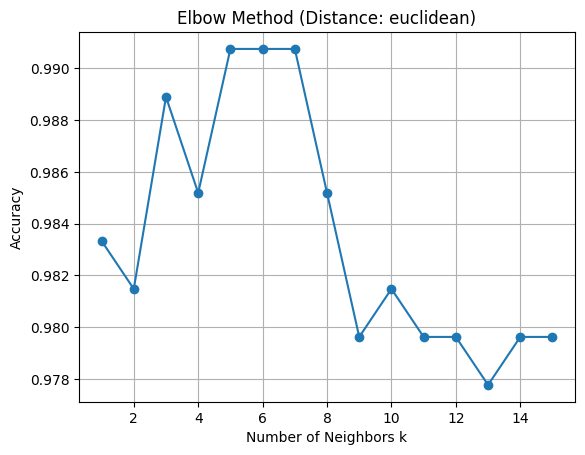

Best k based on accuracy: 5
Final Test Accuracy with k=5: 0.9907


In [6]:
# Try Euclidean Distance
best_k = elbow_method(X_train, X_test, y_train, y_test, max_k=15, metric='euclidean')

# Train final model
knn = KNN(k=best_k, distance_metric='euclidean')
knn.fit(X_train, y_train)
acc = knn.score(X_test, y_test)
print(f'Final Test Accuracy with k={best_k}: {acc:.4f}')


In [7]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, degree=3, coef0=1):
    return (np.dot(x1, x2) + coef0) ** degree

def rbf_kernel(x1, x2, gamma=0.05):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)


In [8]:
class SVM:
    def __init__(self, kernel='linear', C=1.0, lr=0.001, epochs=1000):
        self.C = C
        self.lr = lr
        self.epochs = epochs

        # Kernel
        if kernel == 'linear':
            self.kernel = linear_kernel
        elif kernel == 'polynomial':
            self.kernel = lambda x, y: polynomial_kernel(x, y, degree=3)
        elif kernel == 'rbf':
            self.kernel = lambda x, y: rbf_kernel(x, y, gamma=0.05)
        else:
            raise ValueError("Unsupported kernel")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = np.where(y <= 0, -1, 1)  # convert to -1, 1

        self.alpha = np.zeros(n_samples)
        self.b = 0

        # Compute kernel matrix
        self.K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                self.K[i, j] = self.kernel(X[i], X[j])

        # Train using simplified SMO-like gradient descent
        for epoch in range(self.epochs):
            for i in range(n_samples):
                condition = y[i] * (np.sum(self.alpha * y * self.K[:, i]) + self.b)
                if condition < 1:
                    self.alpha[i] += self.lr * (1 - condition)
                else:
                    self.alpha[i] -= self.lr * self.C * self.alpha[i]

        self.X = X
        self.y = y

    def project(self, X):
        result = []
        for x in X:
            val = 0
            for i in range(len(self.alpha)):
                val += self.alpha[i] * self.y[i] * self.kernel(self.X[i], x)
            result.append(val + self.b)
        return np.array(result)

    def predict(self, X):
        return np.sign(self.project(X))


In [9]:
class MultiClassSVM:
    def __init__(self, kernel='linear', C=1.0, lr=0.001, epochs=1000):
        self.kernel = kernel
        self.C = C
        self.lr = lr
        self.epochs = epochs
        self.models = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            y_binary = np.where(y == cls, 1, -1)
            model = SVM(kernel=self.kernel, C=self.C, lr=self.lr, epochs=self.epochs)
            model.fit(X, y_binary)
            self.models[cls] = model

    def predict(self, X):
        scores = {}
        for cls, model in self.models.items():
            scores[cls] = model.project(X)
        predictions = np.array([max(scores, key=lambda cls: scores[cls][i]) for i in range(X.shape[0])])
        return predictions

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


In [10]:
# Linear Kernel SVM
svm_model = MultiClassSVM(kernel='linear', C=1.0, lr=0.001, epochs=300)
svm_model.fit(X_train, y_train)
acc = svm_model.score(X_test, y_test)
print(f"Linear Kernel SVM Accuracy: {acc:.4f}")


Linear Kernel SVM Accuracy: 0.9667


In [12]:
# RBF Kernel SVM
svm_model_rbf = MultiClassSVM(kernel='rbf', C=1.0, lr=0.001, epochs=300)
svm_model_rbf.fit(X_train, y_train)
acc_rbf = svm_model_rbf.score(X_test, y_test)
print(f"RBF Kernel SVM Accuracy: {acc_rbf:.4f}")


RBF Kernel SVM Accuracy: 0.9611


## Conclusion
In this project, we successfully implemented:

- A custom k-NN model using Euclidean and Manhattan distances.
- k selection via the Elbow Method for optimal performance.
- A custom SVM model using gradient descent and kernel trick for nonlinear decision boundaries.
- Comparison of linear, polynomial, and RBF kernels for multi-class classification.

By building these models from scratch, we developed a deeper understanding of the inner workings of powerful algorithms often treated as black boxes.